In [7]:
from matplotlib import pyplot
import cartopy.crs as ccrs
import rasterio
from rasterio.rio import insp
from rasterio import mask
from rasterio.plot import show, show_hist
from rasterio.warp import calculate_default_transform, reproject, Resampling
# import fiona
# from shapely.geometry import Polygon
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("white")
sns.set(font_scale=1.5)
title = 'output.tif'

dst_crs = 'EPSG:4326'

with rasterio.open("Z:\LWI_StageIV\Hurricane Katrina 2005\ST4.2005082305.01h") as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('ST4.2005082305.01h', 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

src = rasterio.open("ST4.2005082305.01h")


In [8]:
array = src.read(1)
# array[array==0] = np.nan
# array[array==insp.stats(array).max] = np.nan
insp.stats(array)

Stats(min=0.0, max=9999.0, mean=5924.729613328705)

In [9]:
src.nodatavals

(9999.0,)

In [10]:
array_masked = np.ma.masked_equal(array, insp.stats(array).max)
array_masked = np.ma.masked_equal(array_masked, insp.stats(array).min)

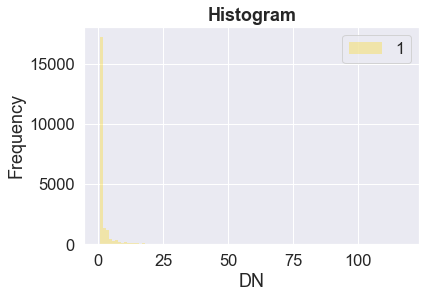

In [11]:
show_hist(array_masked, bins=100, masked=True, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram", label="1")

C:\Tools\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  if __name__ == '__main__':


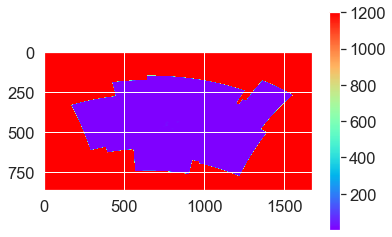

In [12]:
src_masked = np.ma.masked_where(src == insp.stats(array).max ,
                          src,
                          copy=True)


# pyplot.imshow(array_masked, cmap='rainbow', vmin=1, vmax=1200)
pyplot.imshow(src.read(1), cmap='rainbow', vmin=1, vmax=1200)
# pyplot.show()
pyplot.colorbar()

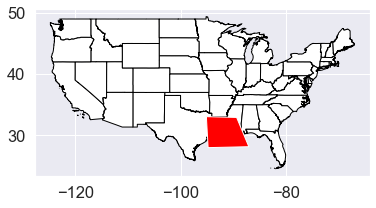

In [13]:

shapefile = gpd.read_file(r"Z:\GIS\StageIv Boundary.shp")
# shapefile.plot()
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = gpd.read_file("Z:\GIS\CONUS.shp")
base = world.plot(color='white', edgecolor='black')
shapefile.plot(ax=base, marker='o', color='red', markersize=5);

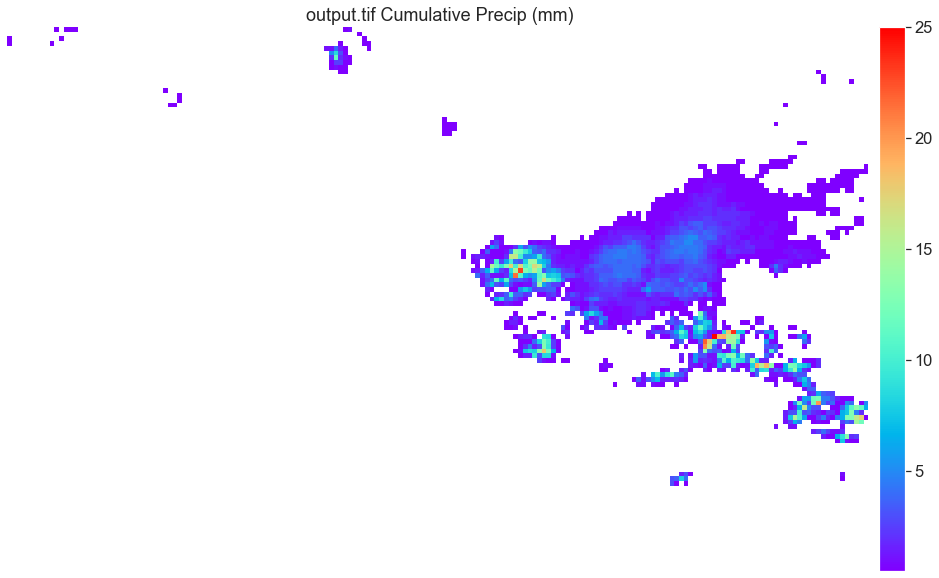

In [22]:
import earthpy.spatial as es
import earthpy.plot as ep
from earthpy.io import path_to_example
import matplotlib.pyplot as plt
# from mpl_toolkits.basemap import Basemap

cropped_raster, cropped_meta = es.crop_image(src, shapefile)
cropped_raster[cropped_raster==0] = np.nan    
cropped_raster[cropped_raster==9999] = np.nan
fig, ax = plt.subplots(figsize = (20, 10))

im = ax.imshow(cropped_raster.squeeze(), cmap='rainbow')
# plt.plot(cropped_raster[1:])
# world.geometry.boundary.plot(ax=ax, color=None, alpha = 1, edgecolor='black', linewidth = 1.0)

ep.colorbar(im)
ax.set(title=f"{title} Cumulative Precip (mm)")
ax.set_axis_off()
plt.savefig(f'{title.split(".")[0]}.png')
# plt.show()

AttributeError: 'AxesImage' object has no property 'projection'

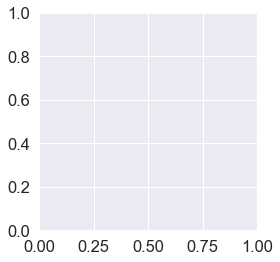

In [113]:
import earthpy.spatial as es
import earthpy.plot as ep
from earthpy.io import path_to_example
import matplotlib.pyplot as plt


    


cropped_raster, cropped_meta = es.crop_image(src, shapefile)
cropped_raster[cropped_raster==0] = np.nan    
cropped_raster[cropped_raster==9999] = np.nan

# rasterio.plot.plotting_extent()
img = rasterio.plot.reshape_as_image(cropped_raster)
# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Mercator()})
# im = ax.imshow(plot_raster, cmap='rainbow')

# ax = plt.axes(projection=ccrs.Mercator())

ax.coastlines()
# ax.set_global()

# im = ax.imshow(cropped_raster.squeeze(), cmap='rainbow')

# img = cropped_raster.squeeze()
# img_proj = ccrs.Geostationary(satellite_height=135786000)
img_extent = rasterio.plot.plotting_extent(cropped_raster, transform=src.transform)
origin = 'upper'
plt.imshow(img, projection=src.crs, extent=img_extent, origin=origin, cmap='rainbow')
# plt.show()

# ep.colorbar(im)
# ax.set(title=f"{title} Cumulative Precip (mm)")
# ax.set_axis_off()
# plt.savefig(f'{title.split(".")[0]}.png')


In [122]:
import fiona
import rasterio
import rasterio.plot
import matplotlib as mpl
from descartes import PolygonPatch

# src = rasterio.open("ST4.2005082305.01h")
new_dataset = rasterio.open('cropped_raster.tif', 'w', driver='GTiff',
                            height = cropped_raster.shape[0], width = cropped_raster.shape[1],
                            count=1, dtype=str(cropped_raster.dtype),
                            crs=src.crs,
                            transform=transform)
new_dataset.write(cropped_raster, 1)
with fiona.open(r"Z:\GIS\CONUS_4326.shp", "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]

rasterio.plot.show((new_dataset, 1))
ax = plt.gca()

patches = [PolygonPatch(feature, edgecolor="red", facecolor="none", linewidth=2) for feature in features]
ax.add_collection(mpl.collections.PatchCollection(patches, match_original=True))

ValueError: Source shape (1, 1, 115, 183) is inconsistent with given indexes 1